# Análise dos Incêndios no Brasil em 2024

Este projeto visa analisar os dados de incêndios florestais no Brasil para o ano de 2024, utilizando técnicas de análise estatística e de séries temporais. Foi tido como objetivo identificar padrões regionais para o risco de fogo, além de verificar a relação entre variáveis climáticas, como o número de dias sem chuva, precipitação e o risco de incêndios.


## Bibliotecas

As principais bibliotecas utilizadas para este projeto incluem:

- `pandas`: Para manipulação de dados e análise tabular.
- `matplotlib` e `seaborn`: Para visualizações gráficas dos dados.
- `statsmodels`: Para análise de regressão e modelos de séries temporais (ARIMA).
- `scikit-learn`: Para pré-processamento de dados e Análise de Componentes Principais (PCA).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

## Carregando dados

Os dados utilizados neste projeto foram extraídos de três quadrimestres de 2024 e foram carregados para análise a partir de arquivos CSV. Cada arquivo contém informações sobre o número médio de dias sem chuva, precipitação, risco de fogo (FRP), e a média de área afetada por incêndios em cada estado.



In [2]:
# Arquivos com cada quadrimestre

df1 = pd.read_csv('/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q1_2024.csv')
df2 = pd.read_csv('/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q2_2024.csv')
df3 = pd.read_csv('/kaggle/input/fire-watch-brazil-2024/Dataset_FireWatch_Brazil_Q3_2024.csv')


In [3]:
# Conferindo os dados

df1.head(), df1.info(),
df2.head(), df2.info(),
df3.head(), df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43753 entries, 0 to 43752
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       43753 non-null  object 
 1   municipio                  43753 non-null  object 
 2   estado                     43753 non-null  object 
 3   bioma                      43752 non-null  object 
 4   avg_numero_dias_sem_chuva  43753 non-null  float64
 5   avg_precipitacao           43753 non-null  float64
 6   avg_risco_fogo             43753 non-null  float64
 7   avg_frp                    43753 non-null  float64
dtypes: float64(4), object(4)
memory usage: 2.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48979 entries, 0 to 48978
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   data                       48979 non-null  object 
 1  

(         data           municipio    estado     bioma  \
 0  2024-07-01  CANDEIAS DO JAMARI  RONDÔNIA  Amazônia   
 1  2024-07-01          CEREJEIRAS  RONDÔNIA  Amazônia   
 2  2024-07-01     ITAPUÃ DO OESTE  RONDÔNIA  Amazônia   
 3  2024-07-01         NOVA MAMORÉ  RONDÔNIA  Amazônia   
 4  2024-07-01     ESPIGÃO D'OESTE  RONDÔNIA  Amazônia   
 
    avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  avg_frp  
 0                      18.10              65.7           25.35   333.65  
 1                      28.00               0.0           58.00    47.00  
 2                      15.67               0.0           70.25   658.08  
 3                      28.00               0.0           71.00    32.50  
 4                      46.50              65.0          100.00    14.00  ,
 None)

In [4]:
# Concatenando os dados

df = pd.concat([df1, df2, df3], ignore_index=True)

In [5]:
# Verificando duplicatas

df.duplicated().sum()

0

## Conhecendo os dados


Percorrer o dataset procurando entender as dimensões das informações geográficas e climáticas que permitirão entender melhor as condições de risco de incêndio ao longo do ano.


In [6]:
df.head()



,data,municipio,estado,bioma,avg_numero_dias_sem_chuva,avg_precipitacao,avg_risco_fogo,avg_frp
0,2024-01-01,VALE DO ANARI,RONDÔNIA,Amazônia,0.0,1698.00,0.0,13.00
1,2024-01-01,SÃO GABRIEL DA CACHOEIRA,AMAZONAS,Amazônia,0.2,206.80,0.0,81.40
2,2024-01-01,MANAQUIRI,AMAZONAS,Amazônia,0.0,60.00,0.0,27.00
3,2024-01-01,JUTAÍ,AMAZONAS,Amazônia,2.0,776.00,0.0,211.00
4,2024-01-01,AUTAZES,AMAZONAS,Amazônia,0.0,2.22,0.0,97.67


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162093 entries, 0 to 162092
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   data                       162093 non-null  object 
 1   municipio                  162093 non-null  object 
 2   estado                     162093 non-null  object 
 3   bioma                      162092 non-null  object 
 4   avg_numero_dias_sem_chuva  162093 non-null  float64
 5   avg_precipitacao           162093 non-null  float64
 6   avg_risco_fogo             162093 non-null  float64
 7   avg_frp                    162089 non-null  float64
dtypes: float64(4), object(4)
memory usage: 9.9+ MB


In [8]:
df.shape


(162093, 8)

In [9]:
df.describe(), df.isnull().sum()

(       avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  \
 count              162093.000000     162093.000000   162093.000000   
 mean                   24.485262        106.525280       58.308355   
 std                    30.996801        470.940061       41.870964   
 min                     0.000000          0.000000        0.000000   
 25%                     3.000000          0.000000        8.500000   
 50%                    10.000000          0.000000       73.890000   
 75%                    35.000000          0.000000      100.000000   
 max                   120.000000      25298.000000      100.000000   
 
              avg_frp  
 count  162089.000000  
 mean      123.318452  
 std       203.294014  
 min         0.000000  
 25%        31.000000  
 50%        59.200000  
 75%       115.830000  
 max      9300.570000  ,
 data                         0
 municipio                    0
 estado                       0
 bioma                        1
 avg_numero_di

## Tratamento dos dados

Para garantir a qualidade dos dados, realizamos as seguintes etapas de tratamento:

- Preenchimento de valores ausentes nas colunas numéricas com a mediana.
- Preenchimento de valores ausentes em colunas categóricas, como biomas, usando a moda.
- Verificação de possíveis outliers e normalização dos dados para realizar a análise.
- Substituir tipo object para datetime em 'data'


In [10]:
df_clean = df.copy()  # Escolhi criar uma cópia do DataFrame original

# Preenchendo os valores nulos nas colunas numéricas com a mediana
df_clean['avg_frp'].fillna(df_clean['avg_frp'].median(), inplace=True)

# Para colunas categóricas, usei a moda
df_clean['bioma'].fillna(df_clean['bioma'].mode()[0], inplace=True)

# Verificar se os valores nulos foram preenchidos
print(df_clean.isnull().sum())

data                         0
municipio                    0
estado                       0
bioma                        0
avg_numero_dias_sem_chuva    0
avg_precipitacao             0
avg_risco_fogo               0
avg_frp                      0
dtype: int64


/tmp/ipykernel_17/483211175.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['avg_frp'].fillna(df_clean['avg_frp'].median(), inplace=True)
/tmp/ipykernel_17/483211175.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

In [11]:
# Object para datatime

df_clean['data'] = pd.to_datetime(df_clean['data'], format='%Y-%m-%d', errors='coerce')

# Verificar o resultado
print(df_clean['data'].head())

0   2024-01-01
1   2024-01-01
2   2024-01-01
3   2024-01-01
4   2024-01-01
Name: data, dtype: datetime64[ns]


In [12]:
df_clean.info(), df_clean.shape, df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162093 entries, 0 to 162092
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   data                       162093 non-null  datetime64[ns]
 1   municipio                  162093 non-null  object        
 2   estado                     162093 non-null  object        
 3   bioma                      162093 non-null  object        
 4   avg_numero_dias_sem_chuva  162093 non-null  float64       
 5   avg_precipitacao           162093 non-null  float64       
 6   avg_risco_fogo             162093 non-null  float64       
 7   avg_frp                    162093 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 9.9+ MB


(None,
 (162093, 8),
         data                 municipio    estado     bioma  \
 0 2024-01-01             VALE DO ANARI  RONDÔNIA  Amazônia   
 1 2024-01-01  SÃO GABRIEL DA CACHOEIRA  AMAZONAS  Amazônia   
 2 2024-01-01                 MANAQUIRI  AMAZONAS  Amazônia   
 3 2024-01-01                     JUTAÍ  AMAZONAS  Amazônia   
 4 2024-01-01                   AUTAZES  AMAZONAS  Amazônia   
 
    avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  avg_frp  
 0                        0.0           1698.00             0.0    13.00  
 1                        0.2            206.80             0.0    81.40  
 2                        0.0             60.00             0.0    27.00  
 3                        2.0            776.00             0.0   211.00  
 4                        0.0              2.22             0.0    97.67  )

## Distribuição dos Dados

Visualizamos as distribuições de algumas variáveis chave:

1. **Número Médio de Dias Sem Chuva**: A distribuição é levemente assimétrica, com muitos registros em torno de valores mais baixos, indicando que a maioria dos estados não enfrenta muitos dias consecutivos sem chuva.

2. **Risco Médio de Fogo**: A distribuição do risco de fogo sugere que a maioria dos estados tem um risco moderado a alto de incêndios.

Essas distribuições nos ajudam a entender a severidade das condições climáticas no Brasil em 2024.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


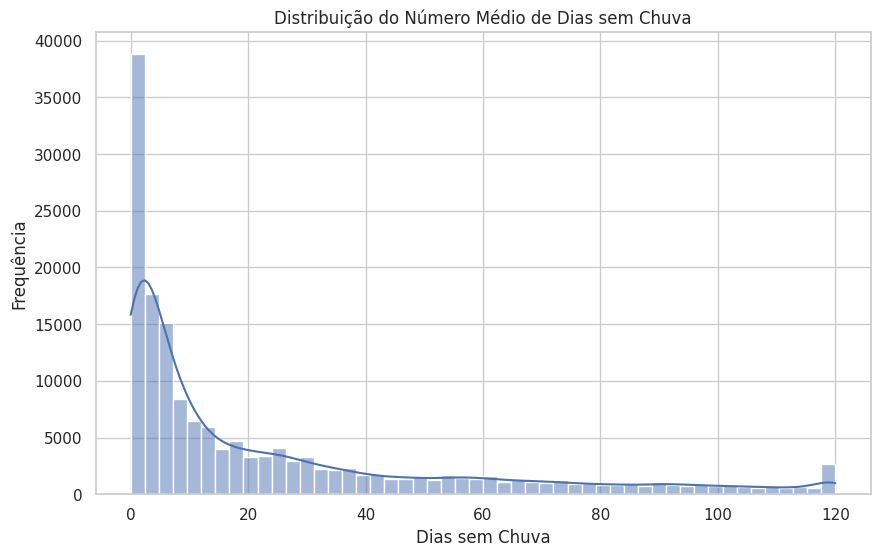

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


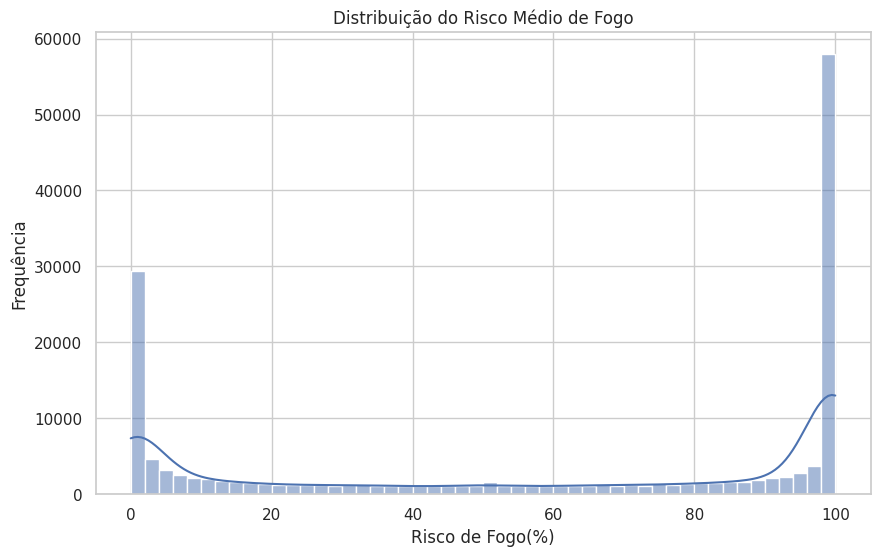

In [13]:
# Tirando algumas distribuições

sns.set(style="whitegrid")

# Distribuição dos dias sem chuva
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['avg_numero_dias_sem_chuva'], bins=50, kde=True)
plt.title('Distribuição do Número Médio de Dias sem Chuva')
plt.xlabel('Dias sem Chuva')
plt.ylabel('Frequência')
plt.show()

# Distribuição do risco de fogo
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['avg_risco_fogo'], bins=50, kde=True)
plt.title('Distribuição do Risco Médio de Fogo')
plt.xlabel('Risco de Fogo(%)')
plt.ylabel('Frequência')
plt.show()

## Análise Regional - Top 10 Estados com Maior Risco de Fogo

Analisamos os 10 estados com maior risco de fogo. Estados como **Mato Grosso** e **Pará** se destacam por apresentarem o risco mais elevado, indicando áreas de maior vulnerabilidade a incêndios florestais. Esses estados também tendem a ser áreas com maior cobertura florestal, como a **Amazônia** e o **Cerrado**.


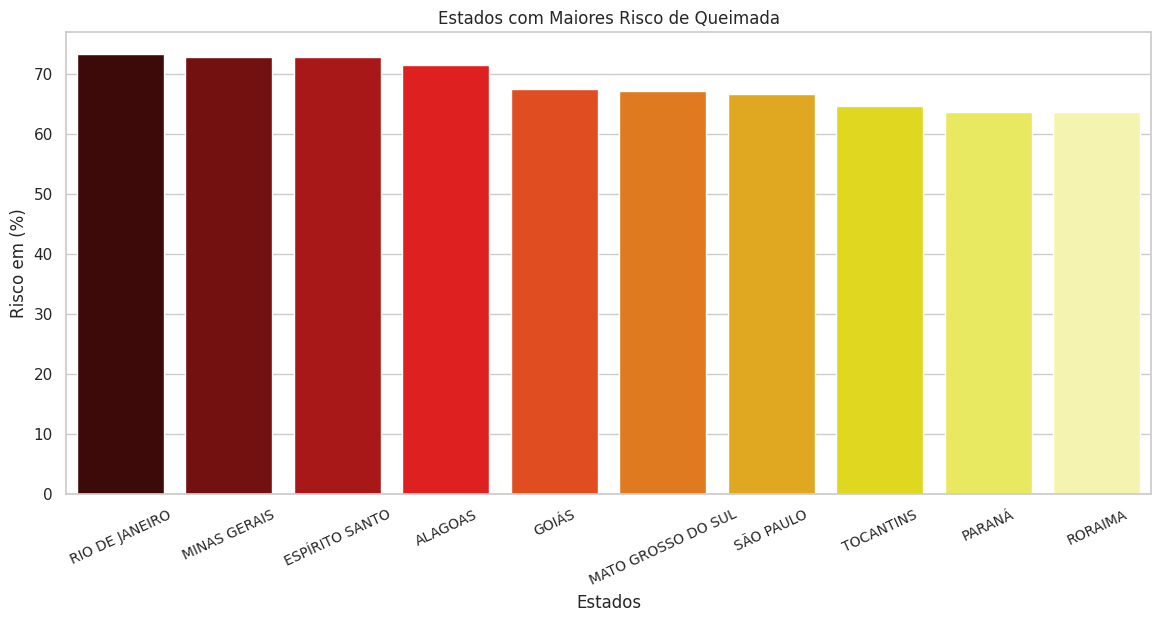

In [14]:
# Top 10 estados com maior risco de fogo
top_estados_risco = df_clean.groupby('estado')['avg_risco_fogo'].mean().nlargest(10).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='estado', y='avg_risco_fogo', data=top_estados_risco, palette='hot')
plt.title('Estados com Maiores Risco de Queimada')
plt.xlabel('Estados')
plt.xticks(rotation=25, fontsize=10)
plt.ylabel('Risco em (%)')
plt.show()

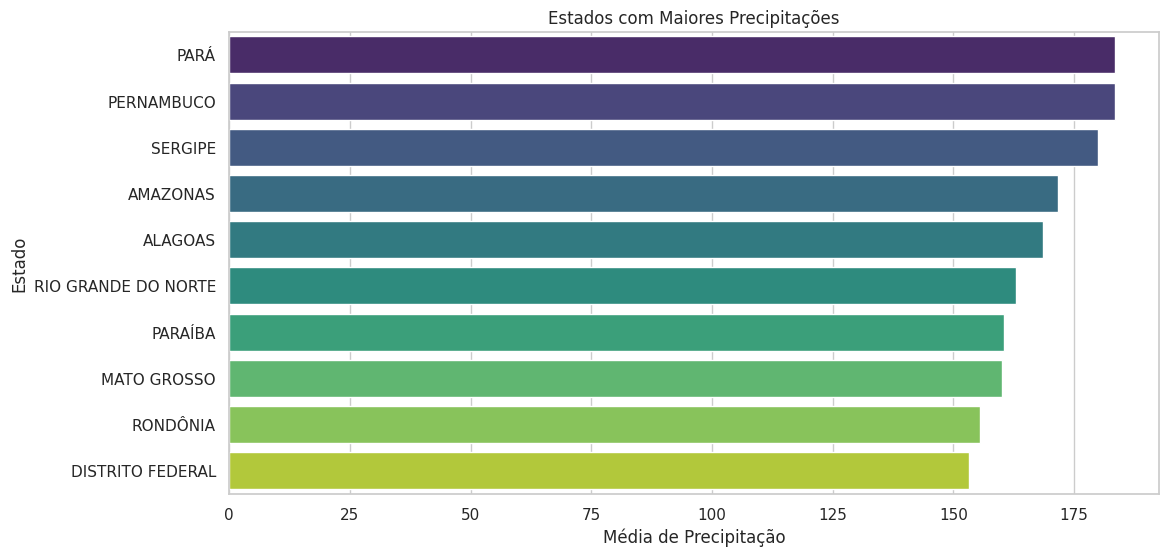

In [15]:
# Top 10 estados com maior precipitação
top_estados_precip = df_clean.groupby('estado')['avg_precipitacao'].mean().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_precipitacao', y='estado', data=top_estados_precip, palette='viridis')
plt.title('Estados com Maiores Precipitações')
plt.xlabel('Média de Precipitação')
plt.ylabel('Estado')
plt.show()

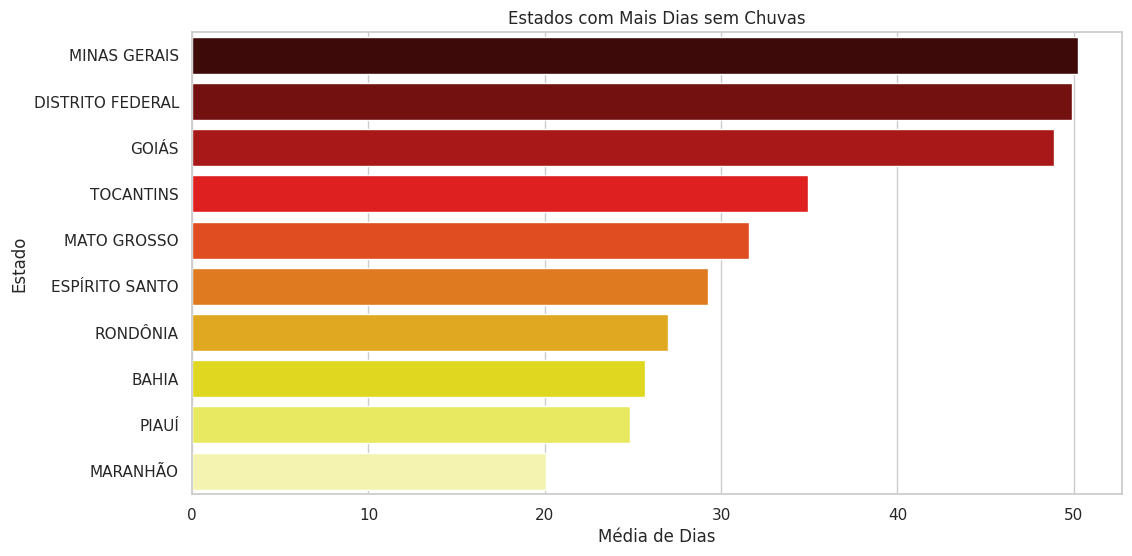

In [16]:
top_estados_dias_sem_chuvas = df_clean.groupby('estado')['avg_numero_dias_sem_chuva'].mean().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_numero_dias_sem_chuva', y='estado', data=top_estados_dias_sem_chuvas, palette='hot')
plt.title('Estados com Mais Dias sem Chuvas')
plt.xlabel('Média de Dias')
plt.ylabel('Estado')
plt.show()

## Análise Regional - Top 10 Biomas

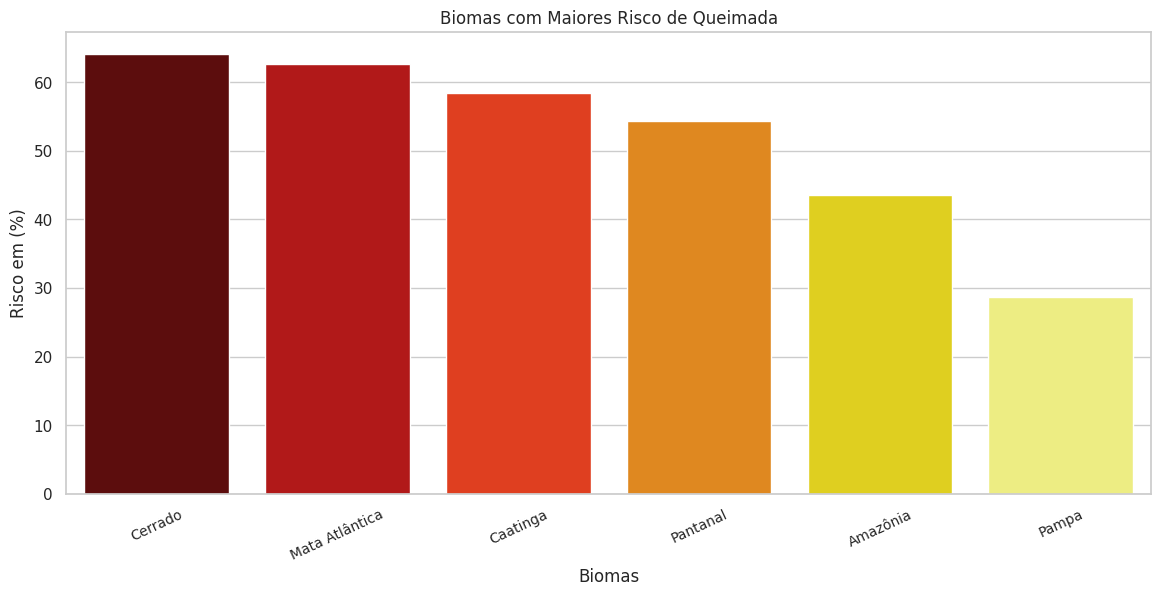

In [17]:
# Top 10 biomas com maior risco de fogo
top_biomas_risco = df_clean.groupby('bioma')['avg_risco_fogo'].mean().nlargest(10).reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='bioma', y='avg_risco_fogo', data=top_biomas_risco, palette='hot')
plt.title('Biomas com Maiores Risco de Queimada')
plt.xlabel('Biomas')
plt.xticks(rotation=25, fontsize=10)
plt.ylabel('Risco em (%)')
plt.show()

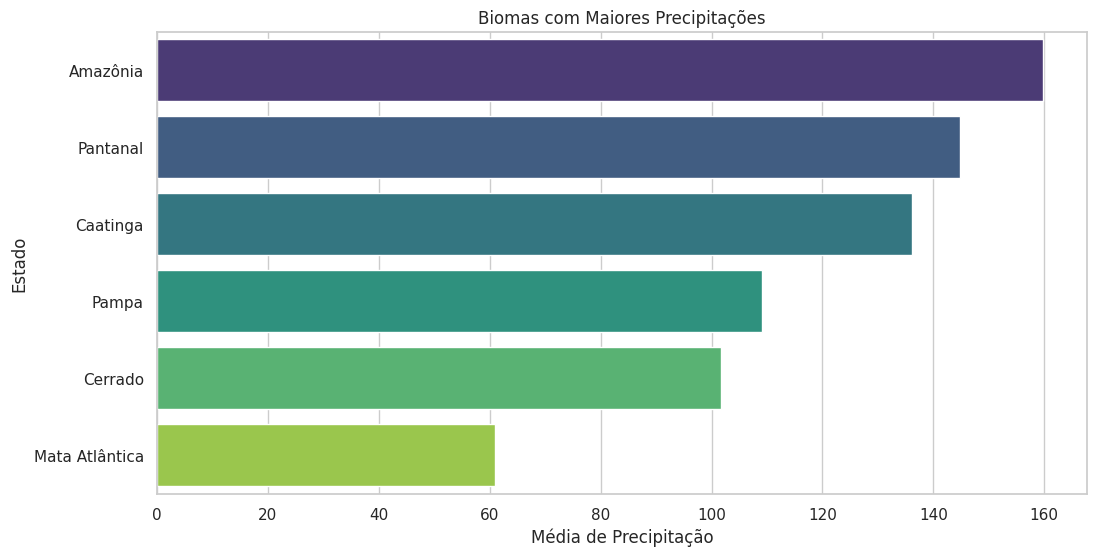

In [18]:
# Top 10 Biomas com maior precipitação
top_biomas_precip = df_clean.groupby('bioma')['avg_precipitacao'].mean().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_precipitacao', y='bioma', data=top_biomas_precip, palette='viridis')
plt.title('Biomas com Maiores Precipitações')
plt.xlabel('Média de Precipitação')
plt.ylabel('Estado')
plt.show()

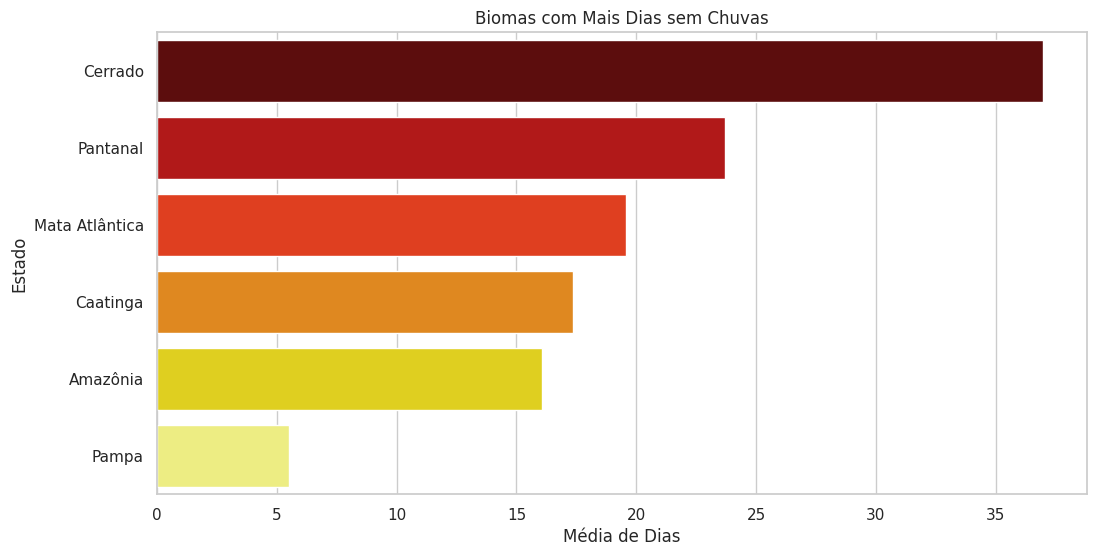

In [19]:
top_biomas_dias_sem_chuvas = df_clean.groupby('bioma')['avg_numero_dias_sem_chuva'].mean().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_numero_dias_sem_chuva', y='bioma', data=top_biomas_dias_sem_chuvas, palette='hot')
plt.title('Biomas com Mais Dias sem Chuvas')
plt.xlabel('Média de Dias')
plt.ylabel('Estado')
plt.show()

## Análise Regional - Top 10 Cidades

In [20]:
# Para facilitar algumas visualizações, defini o seguinte:

def abreviar_estados(df_clean):
    df_clean['estado'] = df_clean['estado'].replace({
        'ACRE': 'AC',
        'ALAGOAS': 'AL',
        'AMAPÁ': 'AP',
        'AMAZONAS': 'AM',
        'BAHIA': 'BA',
        'CEARÁ': 'CE',
        'DISTRITO FEDERAL': 'DF',
        'ESPÍRITO SANTO': 'ES',
        'GOIÁS': 'GO',
        'MARANHÃO': 'MA',
        'MATO GROSSO': 'MT',
        'MATO GROSSO DO SUL': 'MTS',
        'MINAS GERAIS': 'MG',
        'PARÁ': 'PA',
        'PARAÍBA': 'PB',
        'PARANÁ': 'PR',
        'PERNAMBUCO': 'PE',
        'PIAUÍ': 'PI',
        'RIO DE JANEIRO': 'RJ',
        'RIO GRANDE DO NORTE': 'RN',
        'RIO GRANDE DO SUL': 'RS',
        'RONDÔNIA': 'RO',
        'RORAIMA': 'RR',
        'SANTA CATARINA': 'SC',
        'SÃO PAULO': 'SP',
        'SERGIPE': 'SE',
        'TOCANTINS': 'TO'
    })
    return df_clean

# Chamar para fazer a abreviação
df_abreviado = abreviar_estados(df)


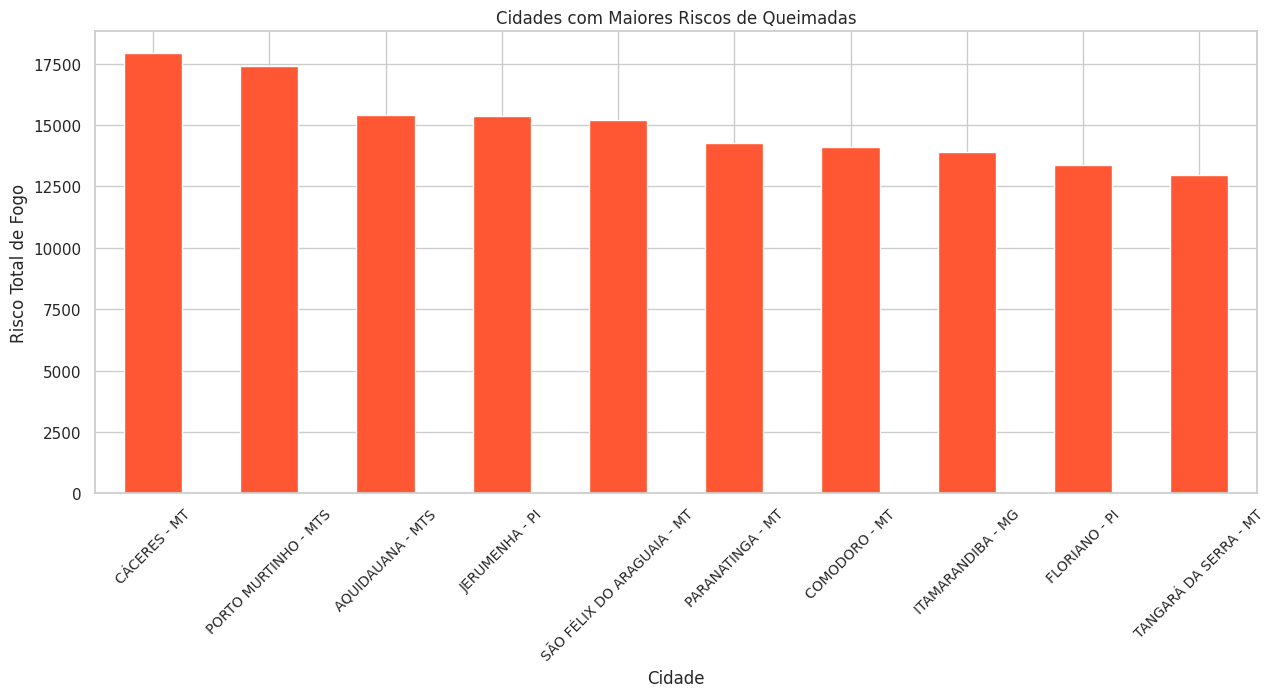

In [21]:
# Criando a coluna 'cidade_estado' combinando cidade e estado abreviado
df_abreviado['cidade_estado'] = df_abreviado['municipio'] + ' - ' + df_abreviado['estado']

# Obtendo os top 10 cidades com mais queimadas
top_cidades_queimadas = df_abreviado.groupby('cidade_estado')['avg_risco_fogo'].sum().nlargest(10)

# Plotando o gráfico
plt.figure(figsize=(15, 6))
top_cidades_queimadas.plot(kind='bar', color='#FF5733')

plt.title('Cidades com Maiores Riscos de Queimadas')
plt.xlabel('Cidade')
plt.ylabel('Risco Total de Fogo')
plt.xticks(rotation=45, fontsize=10) 
plt.show()

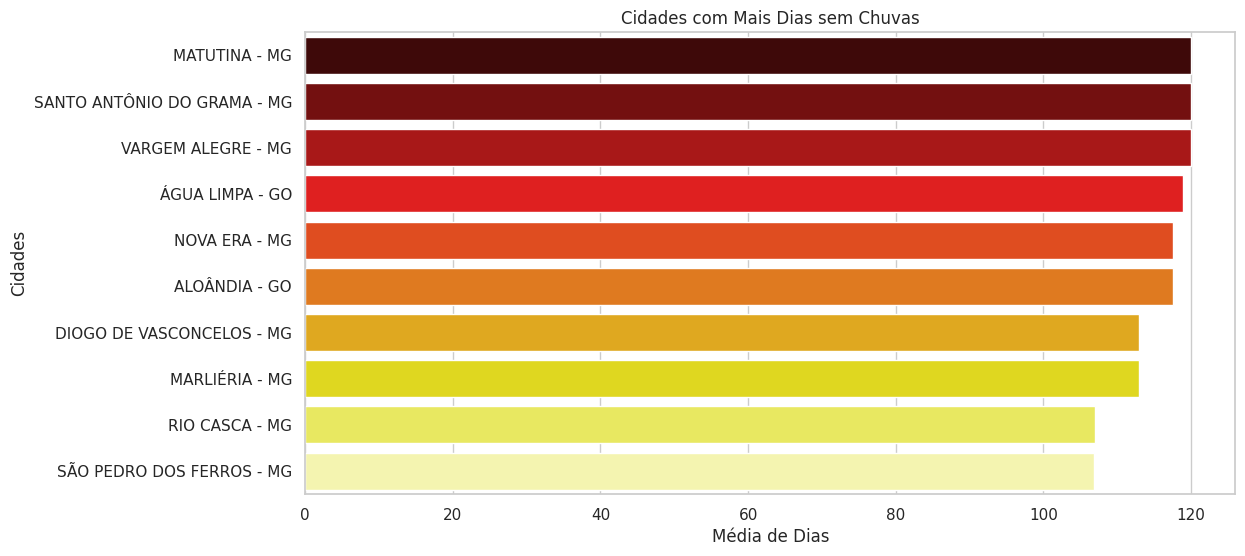

In [22]:
# Cidades com mais dias sem chuvas

df_abreviado['cidade_estado'] = df_abreviado['municipio'] + ' - ' + df_abreviado['estado']
top_cidades_dias_sem_chuvas = df_abreviado.groupby('cidade_estado')['avg_numero_dias_sem_chuva'].mean().nlargest(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_numero_dias_sem_chuva', y='cidade_estado', data=top_cidades_dias_sem_chuvas, palette='hot')
plt.title('Cidades com Mais Dias sem Chuvas')
plt.xlabel('Média de Dias')
plt.ylabel('Cidades')
plt.show()

## Correlação entre Variáveis



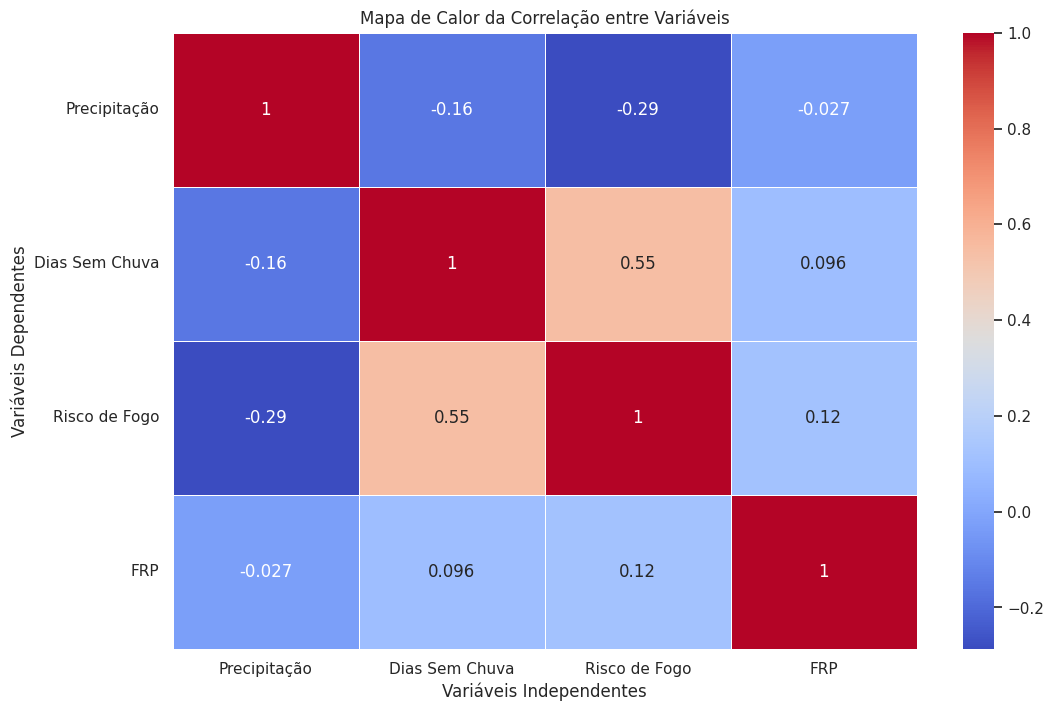

In [23]:
# Heatmap de Correlação das Variáveis
plt.figure(figsize=(12, 8))
corr_matrix = df_clean[['avg_precipitacao', 'avg_numero_dias_sem_chuva', 'avg_risco_fogo', 'avg_frp']].corr()
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor da Correlação entre Variáveis')


heatmap.set_xlabel('Variáveis Independentes', fontsize=12)
heatmap.set_ylabel('Variáveis Dependentes', fontsize=12)

heatmap.set_xticklabels(['Precipitação', 'Dias Sem Chuva', 'Risco de Fogo', 'FRP'], rotation=0)
heatmap.set_yticklabels(['Precipitação', 'Dias Sem Chuva', 'Risco de Fogo', 'FRP'], rotation=0)

plt.show()

## Correlação entre Dias Sem Chuva e Risco de Fogo


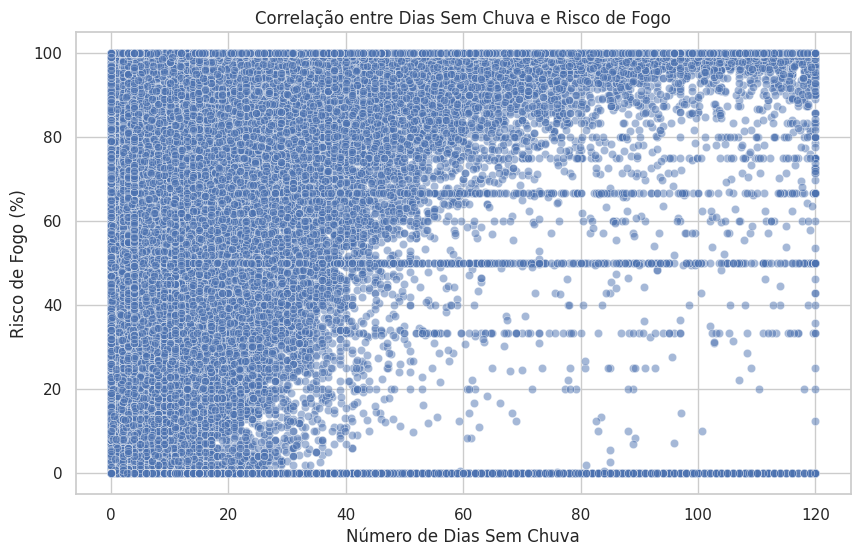

Coeficiente de correlação entre Dias Sem Chuva e Risco de Fogo: 0.547


In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_numero_dias_sem_chuva', y='avg_risco_fogo', data=df_clean, alpha=0.5)
plt.title('Correlação entre Dias Sem Chuva e Risco de Fogo')
plt.xlabel('Número de Dias Sem Chuva')
plt.ylabel('Risco de Fogo (%)')

# Cálculo da correlação de Pearson
correlacao_dias_sem_chuva = pearsonr(df_clean['avg_numero_dias_sem_chuva'], df_clean['avg_risco_fogo'])
plt.show()


print(f"Coeficiente de correlação entre Dias Sem Chuva e Risco de Fogo: {correlacao_dias_sem_chuva[0]:.3f}")


## Interpretação

A correlação de 0.547 sugere que o número de dias sem chuva tem uma influência significativa no risco de fogo. Quando há muitos dias consecutivos sem chuva, o ambiente se torna mais seco, aumentando as condições propícias para o surgimento de incêndios.

No entanto, como a correlação não é próxima de 1, isso indica que o número de dias sem chuva não é o único fator determinante do risco de fogo. Existem outros fatores, como a vegetação, vento, e umidade, que também podem contribuir.

## Correlação entre FRP e Risco de Fogo


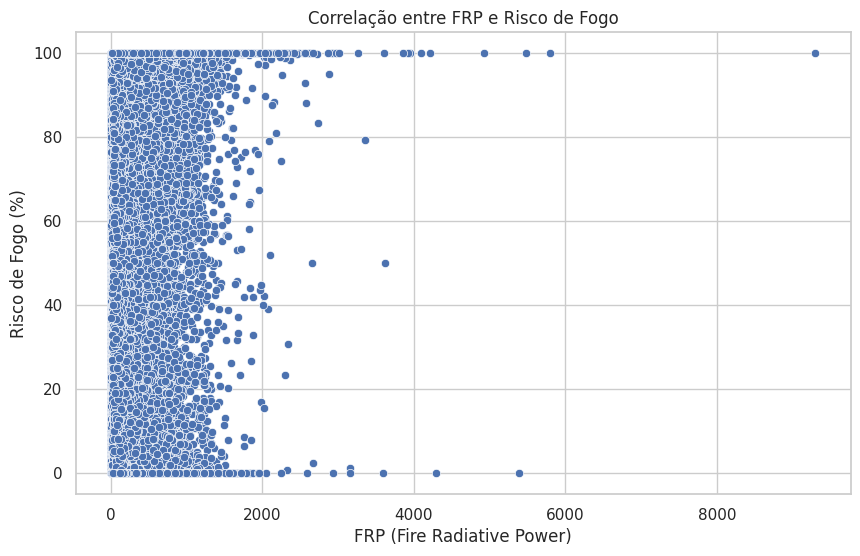

Coeficiente de correlação entre FRP e Risco de Fogo: 0.119


In [25]:
# Scatterplot entre FRP e Risco de Fogo
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_frp', y='avg_risco_fogo', data=df_clean, alpha=1)
plt.title('Correlação entre FRP e Risco de Fogo')
plt.xlabel('FRP (Fire Radiative Power)')
plt.ylabel('Risco de Fogo (%)')

# Cálculo da correlação de Pearson
correlacao_frp_risco = pearsonr(df_clean['avg_frp'], df_clean['avg_risco_fogo'])
plt.show()

print(f"Coeficiente de correlação entre FRP e Risco de Fogo: {correlacao_frp_risco[0]:.3f}")


### Interpretação:

   Um valor de 0.119 sugere que há uma correlação muito fraca entre essas duas variáveis. Embora haja uma leve tendência de que, à medida que o FRP aumenta, o risco de fogo também aumente, essa relação é muito pequena.

   Logo, o coeficiente baixo indica que o FRP não é um bom preditor do risco de fogo. Ou seja, o fato de uma área ter uma maior potência radiante do fogo não necessariamente significa que o risco de fogo será elevado.

## Correlação entre FRP e Dias Sem Chuva


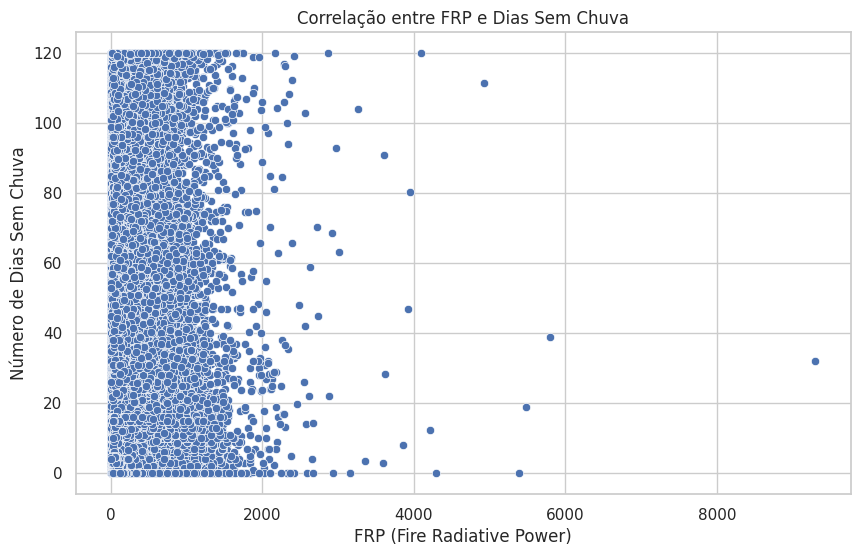

Coeficiente de correlação entre FRP e Dias Sem Chuva: 0.096


In [26]:
# Scatterplot entre FRP e Dias Sem Chuva
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_frp', y='avg_numero_dias_sem_chuva', data=df_clean, alpha=1)
plt.title('Correlação entre FRP e Dias Sem Chuva')
plt.xlabel('FRP (Fire Radiative Power)')
plt.ylabel('Número de Dias Sem Chuva')

# Cálculo da correlação de Pearson
correlacao_frp_dias_sem_chuva = pearsonr(df_clean['avg_frp'], df_clean['avg_numero_dias_sem_chuva'])
plt.show()

print(f"Coeficiente de correlação entre FRP e Dias Sem Chuva: {correlacao_frp_dias_sem_chuva[0]:.3f}")



### Interpretação 

A correlação de 0.096 mostra que o número de dias sem chuva e o FRP não estão fortemente relacionados. Ou seja, o número de dias sem chuva tem muito pouco impacto sobre a potência radiante do fogo.

Uma possível explicação, é que o FRP mede a intensidade de incêndios já em andamento, enquanto o número de dias sem chuva reflete uma condição climática que pode aumentar a probabilidade de incêndios, mas não necessariamente afeta a intensidade de que os incêndios ocorram.

# Análises Estatísticas



In [27]:

# Definindo as variáveis independentes (dias sem chuva, precipitação, FRP)
X = df_clean[['avg_numero_dias_sem_chuva', 'avg_precipitacao', 'avg_frp']]

# Variável dependente (risco de fogo)
y = df_clean['avg_risco_fogo']

# Adicionando uma constante para o modelo 
X = sm.add_constant(X)

# Ajustando o modelo de regressão linear
modelo = sm.OLS(y, X).fit()

# Resumo dos resultados
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:         avg_risco_fogo   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                 2.841e+04
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:06:44   Log-Likelihood:            -8.0110e+05
No. Observations:              162093   AIC:                         1.602e+06
Df Residuals:                  162089   BIC:                         1.602e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Análise dos Resultados da Regressão OLS

A regressão OLS (Mínimos Quadrados Ordinários) fornece insights sobre a relação entre o risco de fogo e as variáveis preditoras: número de dias sem chuva, precipitação e FRP (Potência Radiante do Fogo). Vamos analisar os resultados em detalhes.

1. R-squared (R² = 0.345)

    O R² de 0.345 indica que cerca de 34,5% da variação no risco de fogo pode ser explicada pelas três variáveis independentes no modelo. Embora isso sugira que o modelo tem algum poder preditivo, ainda há uma parcela considerável (65,5%) da variação que não está sendo explicada por essas variáveis.

2. Coeficientes (Coef)

    Constante (Intercepto = 41.7729): Quando todas as variáveis independentes são zero (ou seja, nenhum dia sem chuva, sem precipitação e FRP zero), o risco de fogo médio seria de cerca de 41.77.

    Número de dias sem chuva (coef = 0.6876): Cada aumento de 1 dia sem chuva está associado a um aumento médio de 0.6876 no risco de fogo. Como esse coeficiente é positivo, ele indica que o número de dias sem chuva está fortemente associado ao aumento do risco de fogo. Esse resultado é altamente significativo (P < 0.001).

    Precipitação (coef = -0.0181): A precipitação tem um impacto negativo no risco de fogo, o que faz sentido. Cada milímetro de chuva a mais está associado a uma redução de 0.0181 no risco de fogo. Isso significa que quanto mais chove, menor é o risco de fogo, e essa relação é estatisticamente significativa.

    FRP (coef = 0.0132): Embora o coeficiente seja positivo, indicando que o aumento no FRP (intensidade de fogo) está relacionado ao aumento do risco de fogo, o impacto é muito pequeno. Para cada aumento unitário no FRP, o risco de fogo aumenta em 0.0132. Novamente, a relação é estatisticamente significativa, mas o efeito é pequeno.

3. F-statistic (F = 2.841e+04)

    O valor do F-statistic e a probabilidade associada (P < 0.001) indicam que o modelo geral é altamente significativo, ou seja, pelo menos uma das variáveis independentes está significativamente relacionada ao risco de fogo.

4. Erro padrão (std err)

    Os erros padrão dos coeficientes são muito pequenos, o que aumenta a confiança nas estimativas dos coeficientes.

5. P>|t|

    Todas as variáveis têm um valor-p inferior a 0.001, indicando que cada uma delas tem um impacto estatisticamente significativo no risco de fogo.

## Conclusões:

   - O número de dias sem chuva é a variável que tem o maior impacto positivo no risco de fogo.
   - A precipitação reduz o risco de fogo, como esperado, sendo um fator importante na prevenção de incêndios.
   - O FRP, apesar de ser significativo, tem um impacto pequeno no aumento do risco de fogo, possivelmente refletindo o fato de que a intensidade dos incêndios não está diretamente correlacionada com as condições que propiciam o surgimento de novos incêndios.

# Série Temporal

## 1. Agrupando e Resumindo os Dados


In [28]:
# Agrupar os dados por data, tirando a média das variáveis de interesse

df_grouped = df_clean.groupby('data').agg({
    'avg_numero_dias_sem_chuva': 'mean',
    'avg_precipitacao': 'mean',
    'avg_risco_fogo': 'mean',
    'avg_frp': 'mean'
}).reset_index()

# Definindo o índice como a coluna de data
df_grouped.set_index('data', inplace=True)


print(df_grouped.head())


            avg_numero_dias_sem_chuva  avg_precipitacao  avg_risco_fogo  \
data                                                                      
2024-01-01                   2.879190        401.888016       37.413603   
2024-01-02                   3.083238        383.892092       38.330516   
2024-01-03                   2.414703        190.503792       31.139870   
2024-01-04                   2.473824        250.075104       32.421012   
2024-01-05                   2.578324        151.545716       31.522730   

               avg_frp  
data                    
2024-01-01  208.738219  
2024-01-02  137.255731  
2024-01-03  152.001840  
2024-01-04  135.539539  
2024-01-05  141.940135  


## 2. Visualizando a Série Temporal

Tentando visualizar a série temporal para entender seu comportamento.

In [29]:
df_grouped.tail(30)

,avg_numero_dias_sem_chuva,avg_precipitacao,avg_risco_fogo,avg_frp
data,,,,
2024-08-01,40.714118,8.634178,77.233849,131.013010
2024-08-02,39.923163,9.563749,75.403497,136.191804
2024-08-03,39.277350,14.474808,78.172792,161.079958
2024-08-04,41.786709,15.722360,80.651630,161.608698
2024-08-05,43.069367,16.985365,83.558618,180.078033
2024-08-06,42.829618,4.509523,80.832824,131.261376
2024-08-07,43.192650,12.320300,83.597515,169.187628
2024-08-08,49.325300,21.418772,85.213401,130.318269
2024-08-09,54.877831,41.172601,84.628705,151.129352


In [30]:
# Identificando o índice onde os valores de 'avg_risco_fogo' são iguais a 0
erro_index = df_grouped[df_grouped['avg_risco_fogo'] == 0].index[0]

# Identificando a posição do índice
erro_pos = df_grouped.index.get_loc(erro_index)

# Excluindo todas as linhas a partir do erro pegando até a linha anterior
df_cleaned = df_grouped.iloc[:erro_pos]


In [31]:
df_cleaned.tail(20)

,avg_numero_dias_sem_chuva,avg_precipitacao,avg_risco_fogo,avg_frp
data,,,,
2024-08-08,49.325300,21.418772,85.213401,130.318269
2024-08-09,54.877831,41.172601,84.628705,151.129352
2024-08-10,51.634596,19.937836,83.671816,166.064159
2024-08-11,50.231047,16.414120,80.725432,146.897031
2024-08-12,47.099328,39.987176,78.215992,156.470400
2024-08-13,41.569059,14.339081,78.523246,128.794938
2024-08-14,39.282150,30.392186,78.087287,134.637316
2024-08-15,37.671146,7.140858,79.221598,127.221087
2024-08-16,37.625597,5.829009,82.040299,151.301010


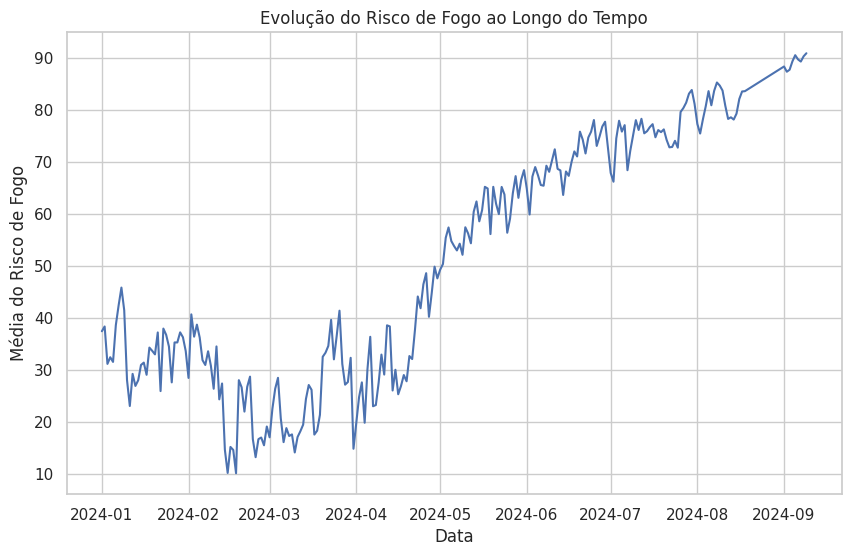

In [32]:
# Plot Série temporal
plt.figure(figsize=(10,6))
plt.plot(df_cleaned['avg_risco_fogo'])
plt.title('Evolução do Risco de Fogo ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Média do Risco de Fogo')
plt.show()


# Principais Descobertas:

   - Número de Dias Sem Chuva: Esta foi a variável mais relevante para aumentar o risco de fogo. Quanto mais tempo uma região permanece sem chuva, maior o risco de incêndios florestais. O impacto dos dias sem chuva foi significativo em diversas regiões do Brasil.

   - Precipitação: A precipitação (quantidade de chuva) tem um efeito inverso no risco de incêndios. Conforme a precipitação aumenta, o risco de incêndios diminui consideravelmente, sendo um fator crucial na prevenção de novos focos de incêndio.

   - Risco de Fogo (FRP - Fire Radiative Power): O FRP, que mede a intensidade dos incêndios, também está relacionado ao risco de fogo, mas de forma muito menos significativa. Mesmo com um coeficiente positivo, o impacto da intensidade do fogo no aumento de novos incêndios foi pequeno.

   - Outliers e Normalização: Durante a análise, os dados passaram por um tratamento para corrigir valores ausentes e normalizar variáveis, o que garantiu a qualidade da análise. Foram preenchidos dados faltantes e removidos outliers para uma análise mais robusta.

   - Distribuição das Variáveis: A análise das distribuições revelou que, em geral, os estados brasileiros possuem baixa média de dias sem chuva, mas as regiões que ultrapassaram esse valor foram as mais propensas a incêndios. Além disso, o comportamento sazonal dos dados também foi analisado, revelando que o período seco é o mais crítico.

   - Impacto Climático no Risco de Incêndios: A relação entre clima e fogo foi reforçada ao longo da análise, mostrando que as mudanças nas condições climáticas, como menos chuva, impactam diretamente a probabilidade e a severidade dos incêndios.

# Conclusão

A análise realizada no projeto mostrou que os incêndios florestais no Brasil em 2024 foram fortemente influenciados por fatores climáticos, especialmente o número de dias sem chuva e a precipitação. A variável mais crítica para o aumento do risco de incêndios foi o número de dias sem chuva, enquanto a precipitação ajudou a reduzir o risco de novos focos de fogo. Embora o FRP também tenha sido significativo, ele teve um impacto pequeno comparado às demais variáveis.

Com essas descobertas, é possível priorizar políticas de prevenção e mitigação focadas nas regiões mais secas e em períodos com maior escassez de chuva, reforçando a importância de monitorar as condições climáticas para antecipar riscos.
